# Introduction
This project aims to train a model to predict under which conditions might a steel production line machine fail. This model is trained [AI4I 2020 Predictive Maintenance Dataset](https://archive.ics.uci.edu/dataset/601/ai4i+2020+predictive+maintenance+dataset).

## Importing libraries & data

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    GridSearchCV
)

from sklearn.metrics import (
    f1_score,
    average_precision_score,
    classification_report,
    precision_score,
    recall_score
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

In [2]:
df = pd.read_csv("Data/ai4i2020.csv")
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


## Column Descriptions

1. **UDI**
  Unique identifier for each data record (row).

2. **Product ID**
  Identifier of the product being manufactured on the machine.

3. **Type**
  Product quality variant (`L` = Low, `M` = Medium, `H` = High), indicating different stress levels on the machine.

4. **Air temperature [K]**
  Ambient air temperature around the machine, measured in Kelvin.

5. **Process temperature [K]**
  Temperature of the manufacturing process, measured in Kelvin.

6. **Rotational speed [rpm]**
  Rotational speed of the machine spindle in revolutions per minute.

7. **Torque [Nm]**
  Torque applied by the machine spindle, measured in Newton-meters.

8. **Tool wear [min]**
  Accumulated tool usage time since last replacement, in minutes.

9. **Machine failure**
  Binary target variable indicating whether a machine failure occurred (`1` = Failure, `0` = No failure).

10. **TWF (Tool Wear Failure)**
  Indicates failure caused by excessive tool wear.

11. **HDF (Heat Dissipation Failure)**
  Indicates failure due to insufficient heat dissipation.

12. **PWF (Power Failure)**
  Indicates failure caused by power-related issues.

13. **OSF (Overstrain Failure)**
  Indicates failure due to mechanical overload or excessive stress.

14. **RNF (Random Failure)**
  Indicates failure due to random or unexplained causes.

Since this EDA is for a binary classification model, using the `failure-type flags` for training could leak the actual target variable `Machine failure`.</br>

# EDA

In [5]:
# check for null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

No null values, this saves a lot of time during preprocessing.

In [4]:
df.describe()

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,5000.50000,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900,0.004600,0.011500,0.009500,0.009800,0.00190
std,2886.89568,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981,0.067671,0.106625,0.097009,0.098514,0.04355
min,1.00000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,2500.75000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,5000.50000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,7500.25000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,10000.00000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


Columns like `Air temperature` & `Process temperature` have a very low spread compared to `Rotational speed`.</br>
This either means that `rpm` has a higher distinguishing factor within the target (`Machine failure`),</br>
or that each unit change in temperature has an intense effect.

In [6]:
df['Machine failure'].value_counts()

Machine failure
0    9661
1     339
Name: count, dtype: int64

The number of failed records are just `3.4%` of the total dataset. Drastically low.</br>
**This is a very _imbalanced_ dataset.** This will effect out training strategy.

## Distribution of numerical columns

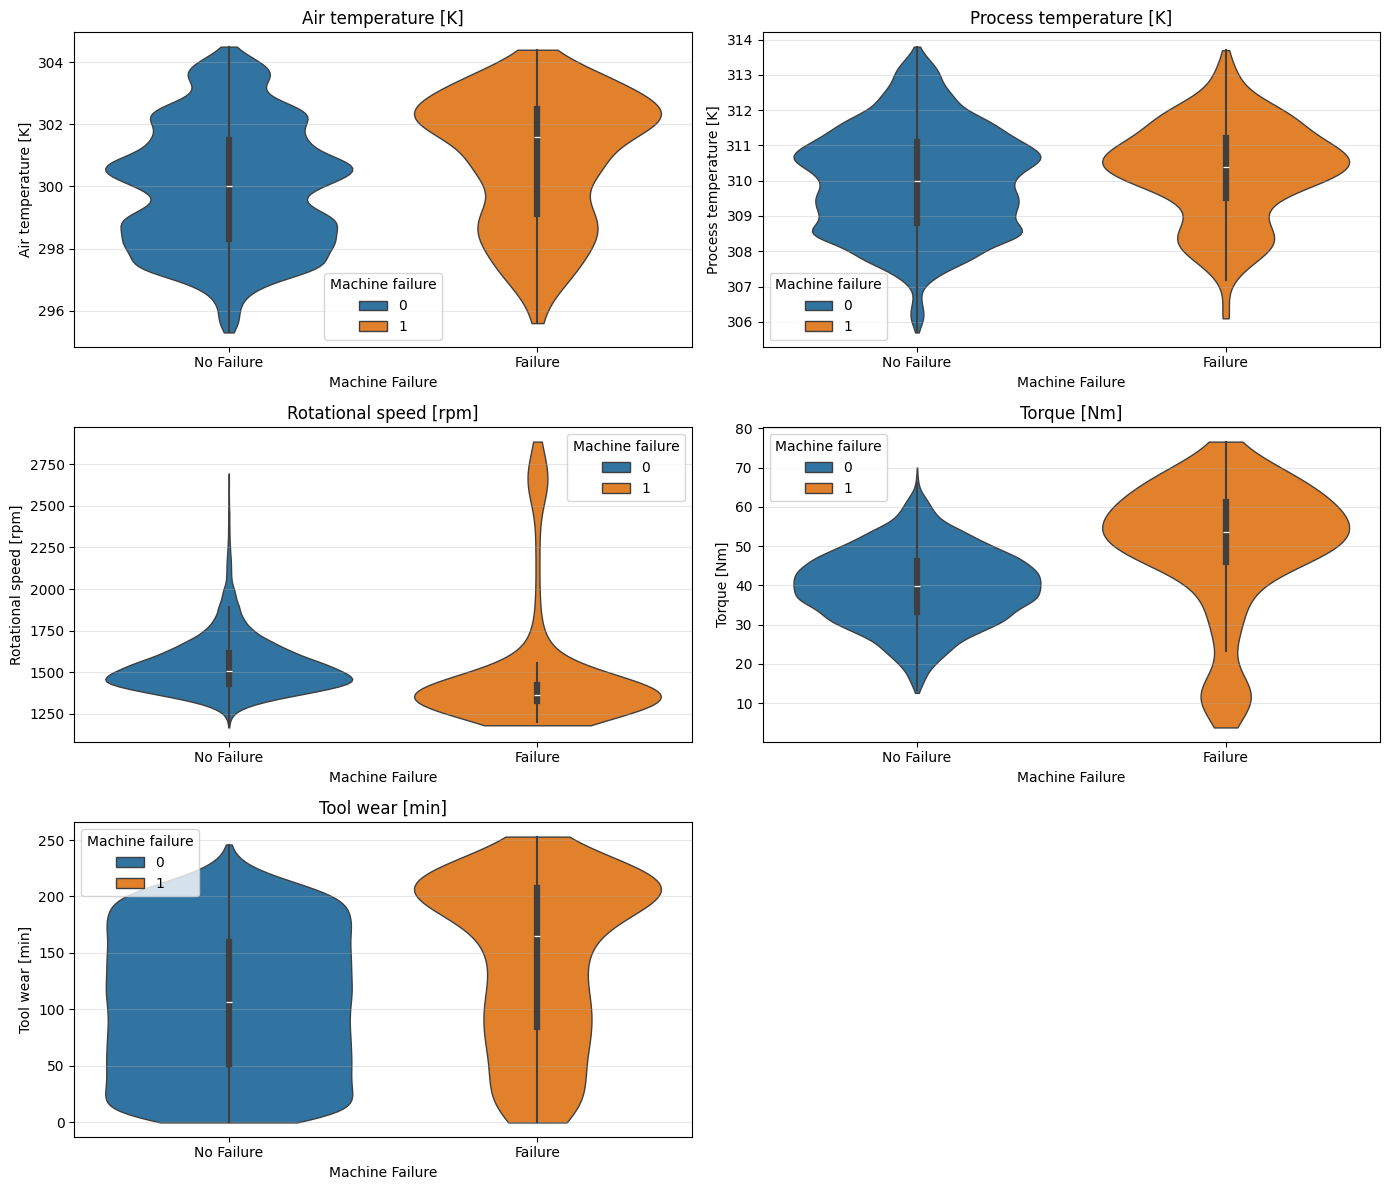

In [29]:
cols = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']

fig, axes = plt.subplots(3, 2, figsize=(14, 12))
axes = axes.flatten()

for i, col in enumerate(cols):
    sns.violinplot(
        data=df,
        x='Machine failure',
        y=col,
        ax=axes[i],
        # inner='quartile',
        cut=0,
        linewidth=1,
        hue='Machine failure'
    )
    axes[i].set_title(col)
    axes[i].set_xlabel('Machine Failure')
    axes[i].set_xticks([0, 1])
    axes[i].set_xticklabels(['No Failure', 'Failure'])
    axes[i].grid(axis='y', alpha=0.3)

# Remove empty subplot
fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

Failed flags in `Torque` & `Tool wear` are isolated within the distribution.</br>
These columns should perform better in tree based models (like `random forest`, `xgboost`, etc)</br>
In the columns `Rotational speed`, the isolated _failed_ `Machine failure` values coincide with the peak in the distribution</br>
this implies that the isolation is just a result of abundant values & not anything semantic happening at values `1250-1500 RPMs`.

## Distributon of categorical column

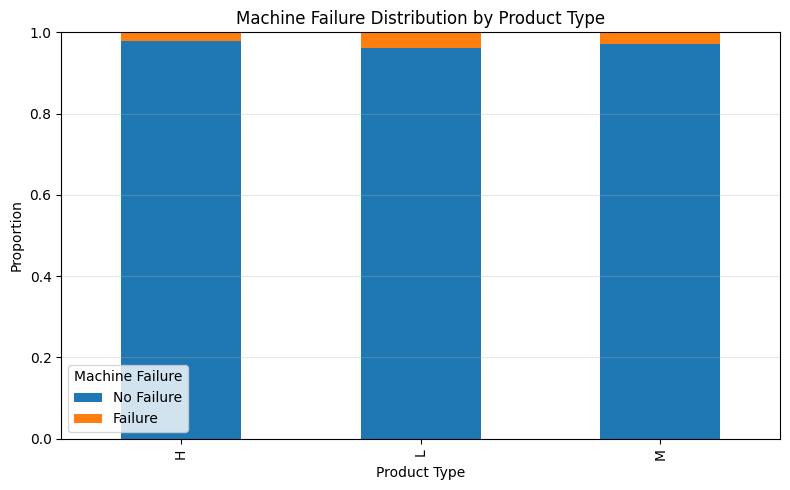

In [20]:
prop_df = (
    df
    .groupby('Type')['Machine failure']
    .value_counts(normalize=True)
    .rename('proportion')
    .reset_index()
)

# Pivot for stacked plotting
pivot_df = prop_df.pivot(
    index='Type',
    columns='Machine failure',
    values='proportion'
)

# Plot
pivot_df.plot(
    kind='bar',
    stacked=True,
    figsize=(8, 5)
)

plt.title('Machine Failure Distribution by Product Type')
plt.ylabel('Proportion')
plt.xlabel('Product Type')
plt.legend(
    title='Machine Failure',
    labels=['No Failure', 'Failure']
)
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

Distribution of `Machine failure` within each category of `Type` is almost the same</br>
This implies that this column probably wouldn't help the performance of tree based models

# Preprocessing

## Feature Encoding
Converting categorical column, Type, using ordinal numerical values

In [30]:
mapping = {'L': 1, 'M': 2, 'H': 3}

df['type_encoded'] = df['Type'].map(mapping)
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF,type_encoded
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0,2
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0,1
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0,1
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0,1
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0,1


## Column renaming

In [33]:
df.rename(columns={
    'Air temperature [K]': 'air_temp_k',
    'Process temperature [K]': 'process_temp_k',
    'Rotational speed [rpm]': 'rotational_speed_rpm',
    'Torque [Nm]': 'torque_nm',
    'Tool wear [min]': 'tool_wear_min',
    'Machine failure': 'machine_failure'
}, inplace=True)
df.head()

,UDI,Product ID,Type,air_temp_k,process_temp_k,rotational_speed_rpm,torque_nm,tool_wear_min,machine_failure,TWF,HDF,PWF,OSF,RNF,type_encoded
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0,2
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0,1
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0,1
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0,1
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0,1


## Feature Selection
Extracting the useful features

In [47]:
cols = [
    'air_temp_k',
    'process_temp_k',
    'rotational_speed_rpm',
    'torque_nm',
    'tool_wear_min',
    'type_encoded'
]

X = df[cols].copy()
y = df['machine_failure']

In [48]:
X.head()

,air_temp_k,process_temp_k,rotational_speed_rpm,torque_nm,tool_wear_min,type_encoded
0,298.1,308.6,1551,42.8,0,2
1,298.2,308.7,1408,46.3,3,1
2,298.1,308.5,1498,49.4,5,1
3,298.2,308.6,1433,39.5,7,1
4,298.2,308.7,1408,40.0,9,1


In [49]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: machine_failure, dtype: int64

## Train-Test split

Since this dataset is _heavily_ imbalanced</br>
I will stratify the split to ensure same distribution in each set

In [50]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [51]:
print("Original distribution:")
print(y.value_counts(normalize=True))

print("\nTrain distribution:")
print(y_train.value_counts(normalize=True))

print("\nTest distribution:")
print(y_test.value_counts(normalize=True))

Original distribution:
machine_failure
0    0.9661
1    0.0339
Name: proportion, dtype: float64

Train distribution:
machine_failure
0    0.966125
1    0.033875
Name: proportion, dtype: float64

Test distribution:
machine_failure
0    0.966
1    0.034
Name: proportion, dtype: float64


## Scaling
Scaling the numerical columns so that they share the same range.</br>This will improve the model's performance.</br></br> Standard scaling is being used, which centers the data around 0 & squeezes them to make the standard deviation 1.

In [52]:
scaler = StandardScaler()

In [53]:
X_train.head()

,air_temp_k,process_temp_k,rotational_speed_rpm,torque_nm,tool_wear_min,type_encoded
4058,302.0,310.9,1456,47.2,54,2
1221,297.0,308.3,1399,46.4,132,2
6895,301.0,311.6,1357,45.6,137,2
9863,298.9,309.8,1411,56.3,84,1
8711,297.1,308.5,1733,28.7,50,1


In [54]:
#seperate out the encoded col
cols = [
    'air_temp_k',
    'process_temp_k',
    'rotational_speed_rpm',
    'torque_nm',
    'tool_wear_min'
]

In [55]:
X_train[cols] = scaler.fit_transform(X_train[cols])
X_test[cols]  = scaler.transform(X_test[cols])

In [56]:
# # converting them back to dfs for easy use
# X_train_scaled = pd.DataFrame(
#     X_train_scaled,
#     columns=cols,
#     index=X_train.index
# )

# X_test_scaled = pd.DataFrame(
#     X_test_scaled,
#     columns=cols,
#     index=X_test.index
# )

In [57]:
X_train.head()

,air_temp_k,process_temp_k,rotational_speed_rpm,torque_nm,tool_wear_min,type_encoded
4058,0.998914,0.604282,-0.460607,0.718305,-0.843997,2
1221,-1.505194,-1.153260,-0.775574,0.638456,0.382263,2
6895,0.498092,1.077466,-1.007654,0.558607,0.460870,2
9863,-0.553633,-0.139294,-0.709265,1.626586,-0.372359,1
8711,-1.455112,-1.018064,1.070019,-1.128202,-0.906882,1


In [58]:
X_test.head()

,air_temp_k,process_temp_k,rotational_speed_rpm,torque_nm,tool_wear_min,type_encoded
2997,0.247681,-0.139294,-1.073963,2.265378,0.712410,1
4871,1.850310,1.618248,-0.145641,0.009646,0.429427,1
3858,1.249324,0.942270,0.108543,-0.239882,1.592802,1
951,-2.206344,-2.505215,-0.167744,-0.419543,-0.749670,3
6463,0.247681,-0.004098,-1.002129,2.035812,-0.089376,3


# Training Models
This is where we train our models on cleaned data

## Logistic Regression

Define the logistic regression model and define cross-validation folds.</br>I'm using stratified cross validation because of target variable is highly imbalanced.

In [60]:
cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

log_reg = LogisticRegression(
    class_weight="balanced",
    max_iter=2000,
    solver="lbfgs"
)

This is where we try to find the optimum model across all the defined parameters.

In [61]:
param_grid = {
    "C": [0.01, 0.1, 1, 10, 100]
}

grid_lr = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    scoring="average_precision",
    cv=cv,
    n_jobs=-1
)

grid_lr.fit(X_train, y_train)

,estimator,LogisticRegre...max_iter=2000)
,param_grid,"{'C': [0.01, 0.1, ...]}"
,scoring,'average_precision'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l2'


Select the best performing model. GridSearch refits to the entire training set by default.</br>Compute `training scores`.

In [62]:
best_lr = grid_lr.best_estimator_
best_pr_auc_cv = grid_lr.best_score_

best_pr_auc_cv

np.float64(0.4475137367509556)

Compute the best threshold for this model

In [72]:
y_proba_test = best_lr.predict_proba(X_test)[:, 1]

thresholds = np.linspace(0.05, 0.5, 50)
f1_scores = []

for t in thresholds:
    y_pred_t = (y_proba_test >= t).astype(int)
    f1_scores.append(f1_score(y_test, y_pred_t))

best_f1 = max(f1_scores)
best_threshold = thresholds[np.argmax(f1_scores)]

Final evaluation at best threshold

In [73]:
y_pred_final = (y_proba_test >= best_threshold).astype(int)
precision = precision_score(y_test, y_pred_final)
recall = recall_score(y_test, y_pred_final)

print(classification_report(y_test, y_pred_final))

              precision    recall  f1-score   support

           0       0.99      0.82      0.90      1932
           1       0.14      0.82      0.24        68

    accuracy                           0.82      2000
   macro avg       0.57      0.82      0.57      2000
weighted avg       0.96      0.82      0.88      2000



The model is behaving how we expect it to behave.</br>
This is a very _pessimistic_ model, identifying more failures.</br>
* very high _recall_: `0.82`
* very low _precision_: `0.14`

This can lead to false positives, but it's better than false negatives.

Store the `training scores` in a df.

In [82]:
metrics_df = pd.DataFrame({
    "model": ["Logistic Regression"],
    "cv_pr_auc": [best_pr_auc_cv],
    "test_precision": [precision],
    "test_recall": [recall],
    "test_f1": [best_f1],
    "best_threshold": [best_threshold]
})

metrics_df

,model,cv_pr_auc,test_precision,test_recall,test_f1,best_threshold
0,Logistic Regression,0.447514,0.139651,0.823529,0.238806,0.5


## Random Forest

We'll repeat the process, of obtaining the best model through grid search cv, again.

Define the randome forest classifier object, without critical hyperparameters.

In [76]:
rf = RandomForestClassifier(
    random_state=42,
    n_jobs=-1
)

Define a parameter space where our grid search will operate.

In [77]:
param_grid_rf = {
    "n_estimators": [200, 400],
    "max_depth": [None, 8, 12],
    "min_samples_leaf": [10, 30, 50],
    "max_features": ["sqrt"],
    "class_weight": ["balanced_subsample"]
}

This parameter grid helps with the imbalanced class</br>
It's also safe for my mid-tier CPU using which these models will train

Now I'll define the grid & find the best estimator

In [78]:
grid_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_rf,
    scoring="average_precision",  # PR-AUC
    cv=cv,
    n_jobs=-1
)

grid_rf.fit(X_train, y_train)

,estimator,RandomForestC...ndom_state=42)
,param_grid,"{'class_weight': ['balanced_subsample'], 'max_depth': [None, 8, ...], 'max_features': ['sqrt'], 'min_samples_leaf': [10, 30, ...], ...}"
,scoring,'average_precision'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,400


In [79]:
best_rf = grid_rf.best_estimator_
best_pr_auc_cv_rf = grid_rf.best_score_

best_pr_auc_cv_rf

np.float64(0.6910014972074343)

Now, I'll calculate the best threshold for this model

In [80]:
y_proba_test_rf = best_rf.predict_proba(X_test)[:, 1]

thresholds = np.linspace(0.05, 0.5, 50)
f1_scores_rf = []

for t in thresholds:
    y_pred_t = (y_proba_test_rf >= t).astype(int)
    f1_scores_rf.append(f1_score(y_test, y_pred_t))

best_f1_rf = max(f1_scores_rf)
best_threshold_rf = thresholds[np.argmax(f1_scores_rf)]

best_threshold_rf, best_f1_rf

(np.float64(0.5), 0.6082474226804123)

That's a good `F1 score`, now we'll store the `precision` & `recall` values

In [81]:
y_pred_final_rf = (y_proba_test_rf >= best_threshold_rf).astype(int)

precision_rf = precision_score(y_test, y_pred_final_rf)
recall_rf = recall_score(y_test, y_pred_final_rf)

print(classification_report(y_test, y_pred_final_rf))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98      1932
           1       0.47      0.87      0.61        68

    accuracy                           0.96      2000
   macro avg       0.73      0.92      0.79      2000
weighted avg       0.98      0.96      0.97      2000



The scores for the positive class look good.</br>
This is better than `Log-Reg` because this model is not as _pessimistic_ as that one</br>
`recall` is consistent (good)</br>
`preicison` score is much better

Nowe we'll store the metrics in a df

In [83]:
metrics_df = pd.concat(
    [
        metrics_df,
        pd.DataFrame({
            "model": ["Random Forest"],
            "cv_pr_auc": [best_pr_auc_cv_rf],
            "test_precision": [precision_rf],
            "test_recall": [recall_rf],
            "test_f1": [best_f1_rf],
            "best_threshold": [best_threshold_rf]
        })
    ],
    ignore_index=True
)

metrics_df

,model,cv_pr_auc,test_precision,test_recall,test_f1,best_threshold
0,Logistic Regression,0.447514,0.139651,0.823529,0.238806,0.5
1,Random Forest,0.691001,0.468254,0.867647,0.608247,0.5


## LightGBM

Same procedure here

In [90]:
# model defination
lgbm = lgb.LGBMClassifier(
    objective="binary",
    random_state=42,
    n_jobs=-1,
    verbosity=-1
)

Now I'll define a parameter grid</br>
somewhere here our best estimator lies

In [87]:
param_grid_lgbm = {
    "n_estimators": [300],
    "learning_rate": [0.05, 0.1],
    "num_leaves": [31, 63],
    "max_depth": [-1, 8],
    "min_child_samples": [20, 50],
    "subsample": [0.8],
    "colsample_bytree": [0.8],
    "is_unbalance": [True]
}

Now we'll train the model

In [91]:
grid_lgbm = GridSearchCV(
    estimator=lgbm,
    param_grid=param_grid_lgbm,
    scoring="average_precision",
    cv=cv,
    n_jobs=-1
)

grid_lgbm.fit(X_train, y_train)

,estimator,LGBMClassifie... verbosity=-1)
,param_grid,"{'colsample_bytree': [0.8], 'is_unbalance': [True], 'learning_rate': [0.05, 0.1], 'max_depth': [-1, 8], ...}"
,scoring,'average_precision'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,boosting_type,'gbdt'


Selecting the best estimator & storing performance scores

In [92]:
best_lgbm = grid_lgbm.best_estimator_
best_pr_auc_cv_lgbm = grid_lgbm.best_score_

best_pr_auc_cv_lgbm

np.float64(0.7861848648122711)

Testing the best decision threshold for this model</br>
and computing/storing scores

In [93]:
y_proba_test_lgbm = best_lgbm.predict_proba(X_test)[:, 1]

thresholds = np.linspace(0.05, 0.5, 50)
f1_scores_lgbm = []

for t in thresholds:
    y_pred_t = (y_proba_test_lgbm >= t).astype(int)
    f1_scores_lgbm.append(f1_score(y_test, y_pred_t))

best_f1_lgbm = max(f1_scores_lgbm)
best_threshold_lgbm = thresholds[np.argmax(f1_scores_lgbm)]

best_threshold_lgbm, best_f1_lgbm

(np.float64(0.5), 0.7938931297709924)

In [94]:
y_pred_final_lgbm = (y_proba_test_lgbm >= best_threshold_lgbm).astype(int)

precision_lgbm = precision_score(y_test, y_pred_final_lgbm)
recall_lgbm = recall_score(y_test, y_pred_final_lgbm)

print(classification_report(y_test, y_pred_final_lgbm))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1932
           1       0.83      0.76      0.79        68

    accuracy                           0.99      2000
   macro avg       0.91      0.88      0.89      2000
weighted avg       0.99      0.99      0.99      2000



The model correctly identifies most normal operations with very high confidence.</br>
For failure cases, it achieves _strong_ precision (`0.83`), indicating few false alarms,</br>
while still detecting `~76%` of failures.

Storing the scores in `metrics_df`

In [95]:
metrics_df = pd.concat(
    [
        metrics_df,
        pd.DataFrame({
            "model": ["LightGBM"],
            "cv_pr_auc": [best_pr_auc_cv_lgbm],
            "test_precision": [precision_lgbm],
            "test_recall": [recall_lgbm],
            "test_f1": [best_f1_lgbm],
            "best_threshold": [best_threshold_lgbm]
        })
    ],
    ignore_index=True
)

metrics_df

,model,cv_pr_auc,test_precision,test_recall,test_f1,best_threshold
0,Logistic Regression,0.447514,0.139651,0.823529,0.238806,0.5
1,Random Forest,0.691001,0.468254,0.867647,0.608247,0.5
2,LightGBM,0.786185,0.825397,0.764706,0.793893,0.5


# Training Evaluation

We compare how each model performed in it's training.</br>

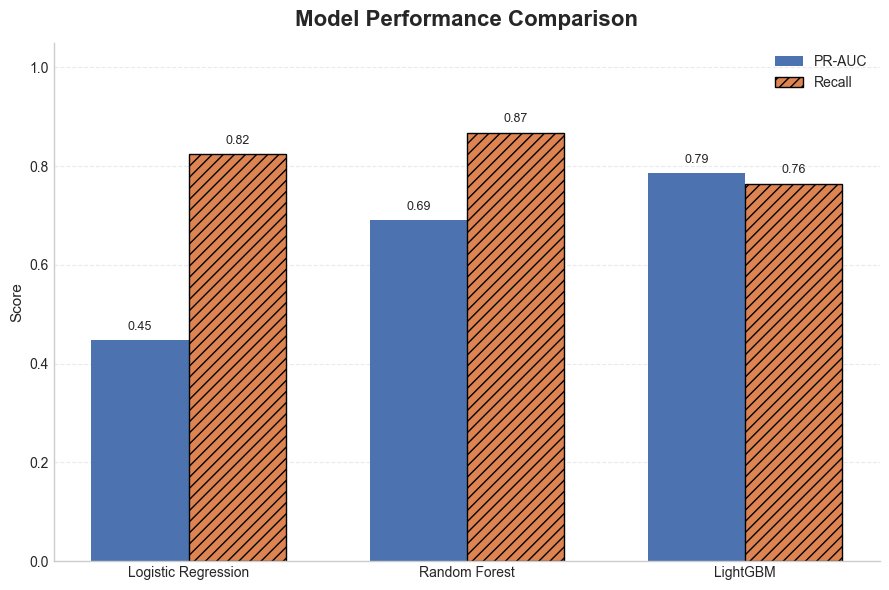

In [106]:
# Extract data
models = metrics_df['model']
pr_auc = metrics_df['cv_pr_auc']
recall = metrics_df['test_recall']

x = np.arange(len(models))
width = 0.35

# Style
plt.style.use('seaborn-v0_8-whitegrid')

fig, ax = plt.subplots(figsize=(9, 6))

# Colors (muted, professional)
pr_color = '#4C72B0'      # blue
recall_color = '#DD8452'  # orange

# Bars
bars_pr = ax.bar(
    x - width/2,
    pr_auc,
    width,
    label='PR-AUC',
    color=pr_color
)

bars_recall = ax.bar(
    x + width/2,
    recall,
    width,
    label='Recall',
    color=recall_color,
    hatch='///',           # 👈 hatch for accessibility
    edgecolor='black'
)

# Title & labels
ax.set_title('Model Performance Comparison', fontsize=16, weight='bold', pad=12)
ax.set_ylabel('Score', fontsize=11)
ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=10)

# Y-axis formatting
ax.set_ylim(0, 1.05)
ax.tick_params(axis='y', labelsize=10)

# Gridlines (readability)
ax.grid(axis='y', linestyle='--', alpha=0.4)
ax.grid(axis='x', visible=False)

# Clean spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Legend (clean)
ax.legend(frameon=False, fontsize=10)

# Value labels
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width()/2,
            height + 0.015,
            f'{height:.2f}',
            ha='center',
            va='bottom',
            fontsize=9
        )

add_labels(bars_pr)
add_labels(bars_recall)

plt.tight_layout()
# plt.savefig(
#     'Screenshots/scores.png',
#     dpi=300,
#     bbox_inches='tight'
# )
plt.show()

### Model Performance Comparison

1. **Logistic Regression**

  * Achieves **high recall (0.82)** but **low PR-AUC (0.45)**.
  * Indicates a **highly pessimistic model** that flags many cases as failures.
  * Suitable when **missing failures is unacceptable**, but generates many false positives.

2. **Random Forest**

  * Improves **PR-AUC (0.69)** while maintaining the **highest recall (0.87)**.
  * Represents a **better balance** between failure detection and false alarms.
  * Strong candidate for **recall-first predictive maintenance**.

3. **LightGBM**

  * Delivers the **highest PR-AUC (0.79)** with slightly lower recall (0.76).
  * Demonstrates **more selective and confident failure predictions**.
  * Best suited when **precision and operational efficiency** are prioritized.

**Overall Trade-off**
Moving from Logistic Regression → Random Forest → LightGBM shows a clear shift:
* from **pessimistic detection**
* to **balanced detection**

Final model choice should depend on whether the business objective prioritizes
    **failure recall** or **false-alarm reduction**

# Conclusion

* The objective of this project was to build a **predictive maintenance model** capable of identifying rare machine failures under **severe class imbalance** (`~97% non-failure`, `~3% failure`), where **missing failures is more costly than false alarms**.

* Multiple models were evaluated using a *consistent* and fair pipeline:

  * stratified train–test split,
  * stratified cross-validation,
  * PR-AUC for model selection,
  * and post-hoc threshold tuning to align predictions with operational goals.

* **Logistic Regression** served as a strong baseline, achieving **high recall** but suffering from **low precision**, resulting in a _pessimistic model_ that over-predicts failures. This makes it suitable only when false positives are largely inconsequential.

* **Random Forest** significantly improved performance by capturing **non-linear relationships**, achieving the **best recall** among all models while also improving precision. This model represents a strong **recall-oriented solution** with better operational balance.

* **LightGBM** delivered the **best overall discrimination**, achieving the highest **PR-AUC** and substantially _higher precision_, while maintaining _acceptable recall_. This indicates more **confident and selective failure predictions**, reducing unnecessary maintenance actions.

* The comparison highlights a clear **precision–recall tradeoff** across models:

  * Logistic Regression: pessimistic, recall-heavy
  * Random Forest: balanced, recall-first
  * LightGBM: operationally efficient

* This project demonstrates that in imbalanced predictive maintenance problems, **model evaluation and threshold selection** are as critical as model choice, and metrics such as **PR-AUC, recall, and precision** provide far more insight than accuracy alone.